In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\one33\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


🔄 Scraping Page 1...
✅ No more pages available.


C:\Users\one33\AppData\Local\Temp\ipykernel_8688\960366394.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Review Sentiment'], palette='viridis')


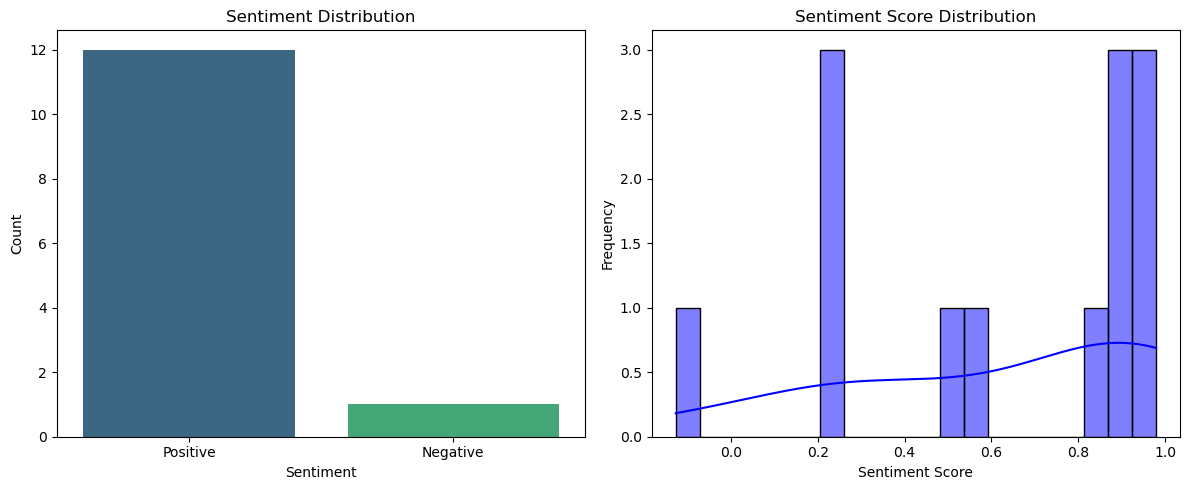

In [2]:
# Download VADER lexicon (only required once)
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to clean review text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to translate reviews to English
def translate_review(review):
    try:
        translated_text = GoogleTranslator(source='auto', target='en').translate(review)
        return translated_text
    except:
        return review  # If translation fails, return original text

# Function to scrape Amazon reviews
def scrape_amazon_reviews(base_url, max_pages=2):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    reviews = []
    page_num = 1

    while page_num <= max_pages:
        print(f"🔄 Scraping Page {page_num}...")
        response = requests.get(base_url, headers=headers)

        if response.status_code != 200:
            print("❌ Failed to retrieve page. Check the URL or try again later.")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        review_blocks = soup.find_all('span', {'data-hook': 'review-body'})

        if not review_blocks:
            print("🚫 No more reviews found.")
            break

        for review in review_blocks:
            review_text = review.get_text(strip=True)
            reviews.append(review_text)

        # Find the next page link
        next_page = soup.find('li', class_='a-last')
        if next_page and next_page.find('a'):
            next_page_url = "https://www.amazon.in" + next_page.find('a')['href']
            base_url = next_page_url  # Update URL for next page
            time.sleep(2)  # Avoid getting blocked
        else:
            print("✅ No more pages available.")
            break

        page_num += 1

    return reviews

# Function to visualize sentiment distribution
def visualize_data(df):
    plt.figure(figsize=(12, 5))

    # 1️⃣ Bar Chart for Sentiment Count
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['Review Sentiment'], palette='viridis')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    # 2️⃣ Histogram for Sentiment Score
    plt.subplot(1, 2, 2)
    sns.histplot(df['Sentiment Score'], bins=20, kde=True, color="blue")
    plt.title("Sentiment Score Distribution")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Main script execution
if __name__ == "__main__":
    base_url = "https://www.amazon.in/AmazonBasics-Height-Adjustable-5-Shelves-Heavy/dp/B018YLFJX4"  # Replace with the actual product review URL
    reviews = scrape_amazon_reviews(base_url, max_pages=2)

    if reviews:  # Check if the list is not empty
        # Translate, clean, and analyze sentiment
        processed_reviews = [translate_review(clean_text(review)) for review in reviews]
        sentiment_scores = [sia.polarity_scores(review)['compound'] for review in processed_reviews]

        # Create DataFrame
        df = pd.DataFrame({'Review': processed_reviews, 'Sentiment Score': sentiment_scores})
        df['Review Sentiment'] = df['Sentiment Score'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

        # Visualize Data
        visualize_data(df)
    else:
        print("❌ No reviews found.")

In [3]:
df

,Review,Sentiment Score,Review Sentiment
0,very sturdy i thought it was good for the pric...,0.2382,Positive
1,pros good storage spacebeautiful strong shelve...,0.9186,Positive
2,i am very happy with the design and the ease w...,0.5017,Positive
3,1 well designed unit with clear selfassembly i...,0.9788,Positive
4,it is very loose no way to tighten it no use d...,-0.1270,Negative
5,worth buyingread more,0.2263,Positive
6,the rack arrived nicely packed it was very sim...,0.5574,Positive
7,the product quality is good but the accessorie...,0.2382,Positive
8,Excellent product very easy to assemble quite ...,0.9152,Positive
9,this shelving unit is exactly what i needed to...,0.9623,Positive


In [5]:
df.to_csv("amazon_product_review_sentiment_analysis.csv")